Ce notebook va servir à la création de notre vecteur Y et notre tableau X de 2006 à 2022 sur la saison estivale afin d'appliquer ensuite nos modèles de prédiction.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString, Polygon

In [2]:
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 6.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.3/411.3 kB 18.3 MB/s eta 0:00:00
  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to /tmp/pip-req-build-_w8czm16
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-_w8czm16
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [3]:
import cartiflette.s3 as s3

## Base de données des communes des Landes ##

Pour avoir toutes les communes des Landes et pas uniquement celles présente dans BDIFF, on importe la base suivante

In [4]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'

df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
#print(df_communes.head())

# Filtrer pour garder uniquement les communes des Landes (codes INSEE commençant par '40')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  
1555         0.769070   1038    14.58  
1556         0.764158    379    33.18  
1557         0.767567     81    41.96  
1558         0.772177    637   117.31  
1559         0.766970     67    10.02  


## Création du vecteur Y ##

Y est un vecteur de 0 et de 1. Chaque ligne correspond à une commune, qui vont être répétées de 2006 à 2022 :
- $Y_1$ = 1 si il y a eu au moins un feu dans la commune 1 sur la période estivale en 2006, 0 sinon
- $Y_2$ = 1 si il y a eu au moins un feu dans la commune 2 sur la période estivale en 2006, 0 sinon
  ...

In [5]:
data = 'combine.csv'

df = pd.read_csv('combine.csv', sep=';')
#print(df.head())

# Pour les Landes
bdiff_landes = df[df['Département'] == '40']
print(bdiff_landes.head())

     Année  Numéro Département Code INSEE  Nom de la commune  \
652   2006    1876          40      40006          Arengosse   
653   2006    1877          40      40151             Lesgor   
654   2006    1878          40      40108             Gastes   
655   2006    1879          40      40210  Onesse-et-Laharie   
656   2006    1881          40      40167              Luxey   

    Date de première alerte Origine de l'alerte  \
652        26/07/2006 19:40         Indéterminé   
653        17/07/2006 15:29         Indéterminé   
654        25/04/2006 18:40         Indéterminé   
655        17/07/2006 18:20         Indéterminé   
656        27/07/2006 10:49         Indéterminé   

     Moyens de première intervention  Surface parcourue (m2)  \
652                              NaN                    5000   
653                              NaN                   66000   
654                              NaN                     400   
655                              NaN                

*Test uniquement pour l'année 2006*

In [6]:
# Conversion du format de la date
bdiff_landes.loc[:, 'Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')

# Filtrer pour l'été 2006
bdiff_landes_2006 = bdiff_landes[bdiff_landes['Année'] == 2006]
df_summer = bdiff_landes_2006[bdiff_landes_2006['Date de première alerte'].dt.month.isin([6, 7, 8])]

# Aggrégation par commune avec vérification des incendies
feu_par_commune = df_summer.groupby('Code INSEE').size().gt(0).reset_index(name='Feu en été')

# Convertir les valeurs en 1 et 0
feu_par_commune['Feu en été'] = feu_par_commune['Feu en été'].astype(int)

# Liste complète des communes des Landes
communes_landes = data_landes[['Insee']].rename(columns={'Insee': 'Code INSEE'})

# Jointure avec la liste des communes des Landes pour inclure toutes les communes
Y = communes_landes.merge(feu_par_commune, on='Code INSEE', how='left')
Y['Feu en été'] = Y['Feu en été'].fillna(0).astype(int)

print(Y)

AttributeError: Can only use .dt accessor with datetimelike values

*De 2006 à 2022, avec toutes les communes*

In [7]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'
df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
data = 'combine.csv'
df = pd.read_csv('combine.csv', sep=';')
bdiff_landes = df[df['Département'] == '40']
bdiff_landes['Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')
communes_landes = data_landes[['Insee']].rename(columns={'Insee': 'Code INSEE'})

# Initialisation du DataFrame final
Y = pd.DataFrame()

annees = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

for annee in annees:
    df_annee = bdiff_landes[bdiff_landes['Année'] == annee]
    df_summer = df_annee[df_annee['Date de première alerte'].dt.month.isin([6, 7, 8])]
    feu_par_commune = df_summer.groupby('Code INSEE').size().gt(0).reset_index(name='Feu en été')
    feu_par_commune['Feu en été'] = feu_par_commune['Feu en été'].astype(int)
    resultat_annuel = communes_landes.merge(feu_par_commune, on='Code INSEE', how='left')
    resultat_annuel['Feu en été'] = resultat_annuel['Feu en été'].fillna(0).astype(int)
    resultat_annuel['Année'] = annee  # Ajout de la colonne Année
    Y = pd.concat([Y, resultat_annuel], ignore_index=True)

print(Y)

     Code INSEE  Feu en été  Année
0          4001           0   2006
1          4004           0   2006
2          4005           0   2006
3          4006           0   2006
4          4007           0   2006
...         ...         ...    ...
6948      40330           0   2022
6949      40331           1   2022
6950      40332           1   2022
6951      40333           0   2022
6952      40334           0   2022

[6953 rows x 3 columns]


/tmp/ipykernel_384/3960158939.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdiff_landes['Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')


In [8]:
Y.to_csv('feux_par_communes.csv', index=False)

## Correspondance commune / maille ##

Afin de pouvoir manipuler les IFM (calculés au coin de chaque maille), et le nombre de feu (connu par commune), et pouvoir ensuite faire nos régressions par maille, il faut arriver à trouver le lien entre les communes et les mailles.

Pour ça, nous avons à notre disposition la base maille_landes, correspondant aux mailles SAFRAN utilisés par le DRIAS pour calculer les IFM, et la base Codes-INSEE_communes, avec toutes les communes des Landes.

*Pour rappel, la base Codes-INSEE*

In [9]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'

df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
#print(df_communes.head())

# Filtrer pour garder uniquement les communes des Landes (codes INSEE commençant par '40')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  
1555         0.769070   1038    14.58  
1556         0.764158    379    33.18  
1557         0.767567     81    41.96  
1558         0.772177    637   117.31  
1559         0.766970     67    10.02  


*Et la base mailles_landes*

In [10]:
data_safran = 'mailles_landes_etendues.csv'

df_safran = pd.read_csv(data_safran)
print(df_safran.head())

   Unnamed: 0  maille_safran  maille_drias   latitude  longitude  altitude  \
0        6423           7577          6181  44.591720  -1.239108        28   
1        6424           7578          6182  44.594946  -1.138519        18   
2        6425           7579          6183  44.598081  -1.037918        12   
3        6504           7659          6038  44.519847  -1.234534        32   
4        6505           7660          6039  44.523069  -1.134073        24   

    departement region_avant_2016          region2016          nature  ...  \
0  33 - Gironde         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
1  33 - Gironde         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
2  33 - Gironde         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
3  33 - Gironde         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
4  33 - Gironde         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   

   clc_311  clc_312  clc_313   rupro  rupromin  rupromax   pro

# 1- Correspondance avec la base INSEE ?
Dessiner la carte des communes des Landes en plaçant des points aux coordonnées latitude/longitude des deux bases afin de voir si ils coincident

In [11]:
## 1- télécharger la carte des communes

communes_landes = s3.download_vectorfile_url_all(
    values="40",  # Code département des Landes
    crs=4326,  
    borders="COMMUNE",  
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",  
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Calcul de l'aire des communes en mètre carré (projection en Lambert-93)
communes_landes["area"] = communes_landes.to_crs(2154).area

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=40/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.12MiB [00:00, 22.7MiB/s]
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [12]:
## 2- convertir les coordonnées de la base insee en degré et non pas en radians

data_landes.loc[:, 'longitude_degrees'] = np.degrees(data_landes.loc[:, 'longitude_radian'])
data_landes.loc[:, 'latitude_degrees'] = np.degrees(data_landes.loc[:, 'latitude_radian'])

print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  longitude_degrees  latitude_degrees  
1555         0.769070   1038    14.58           6.130000         44.064445  
1556         0.764158    379    33.18           6.007500         43.783054  
1557         0.767567     81    41.96           6.594444         43.978333  
1558         0.772177    637   117.31           6.626389         44.242500  
1559         0.766970     67    10.02           6.557222         43.944168  


/tmp/ipykernel_384/4083701067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_landes.loc[:, 'longitude_degrees'] = np.degrees(data_landes.loc[:, 'longitude_radian'])
/tmp/ipykernel_384/4083701067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_landes.loc[:, 'latitude_degrees'] = np.degrees(data_landes.loc[:, 'latitude_radian'])


In [13]:
## 3- conversion des GeoDataFrame

geometry_landes = [Point(xy) for xy in zip(data_landes['longitude_degrees'], data_landes['latitude_degrees'])]
geo_data_landes = gpd.GeoDataFrame(data_landes, geometry=geometry_landes)

geometry_safran = [Point(xy) for xy in zip(df_safran['longitude'], df_safran['latitude'])]
geo_df_safran = gpd.GeoDataFrame(df_safran, geometry=geometry_safran)

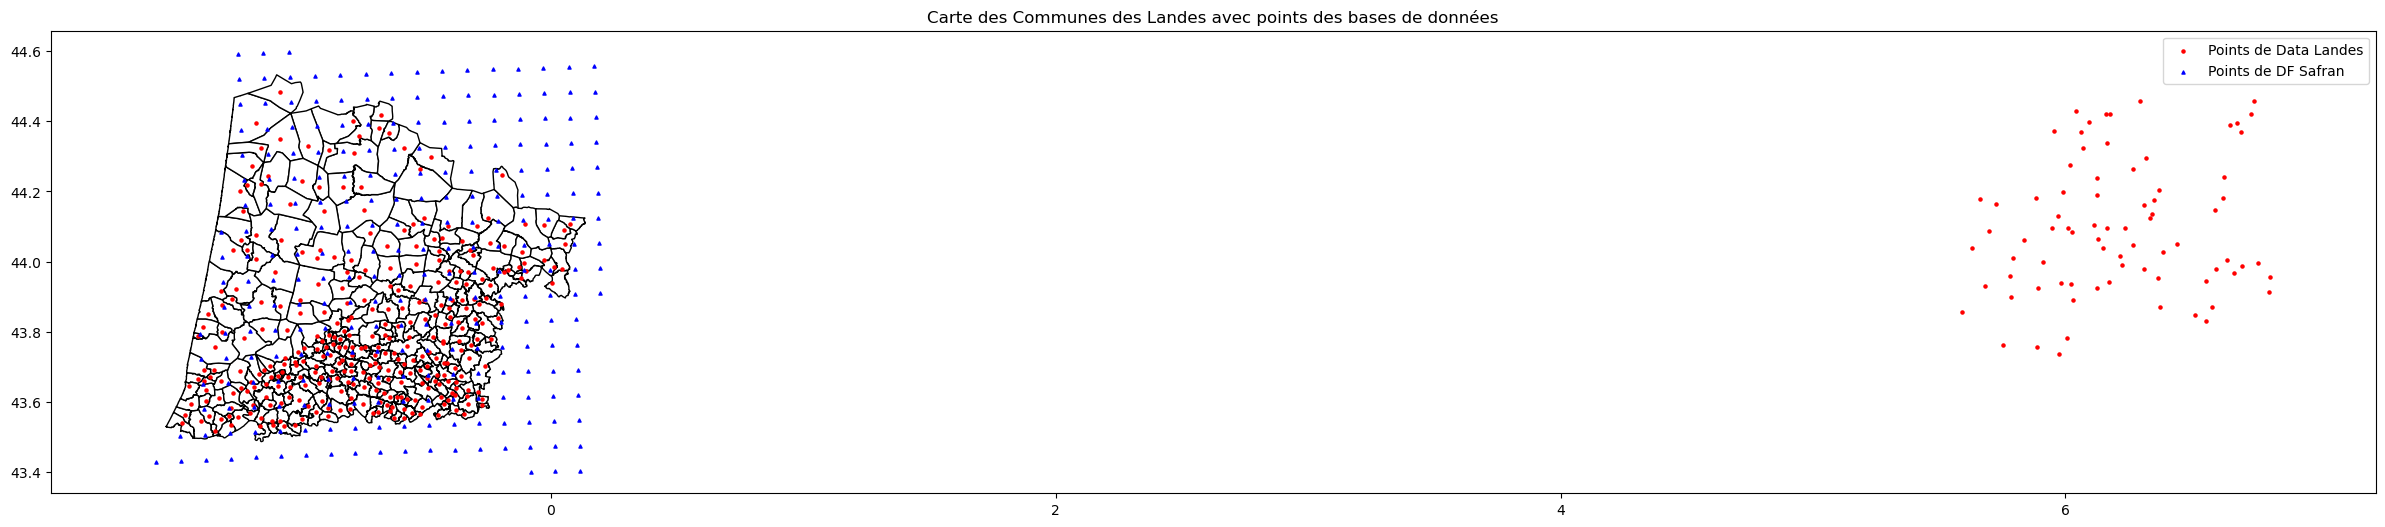

In [14]:
## 4- visualisation avec la shapeline des communes 

# Assurer que toutes les données sont dans le même système de coordonnées
geo_data_landes = geo_data_landes.set_crs(epsg=4326)  # WGS 84
geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et geo_df_safran à la carte
geo_data_landes.plot(ax=ax, marker='o', color='red', markersize=5, label='Points de Data Landes')
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()


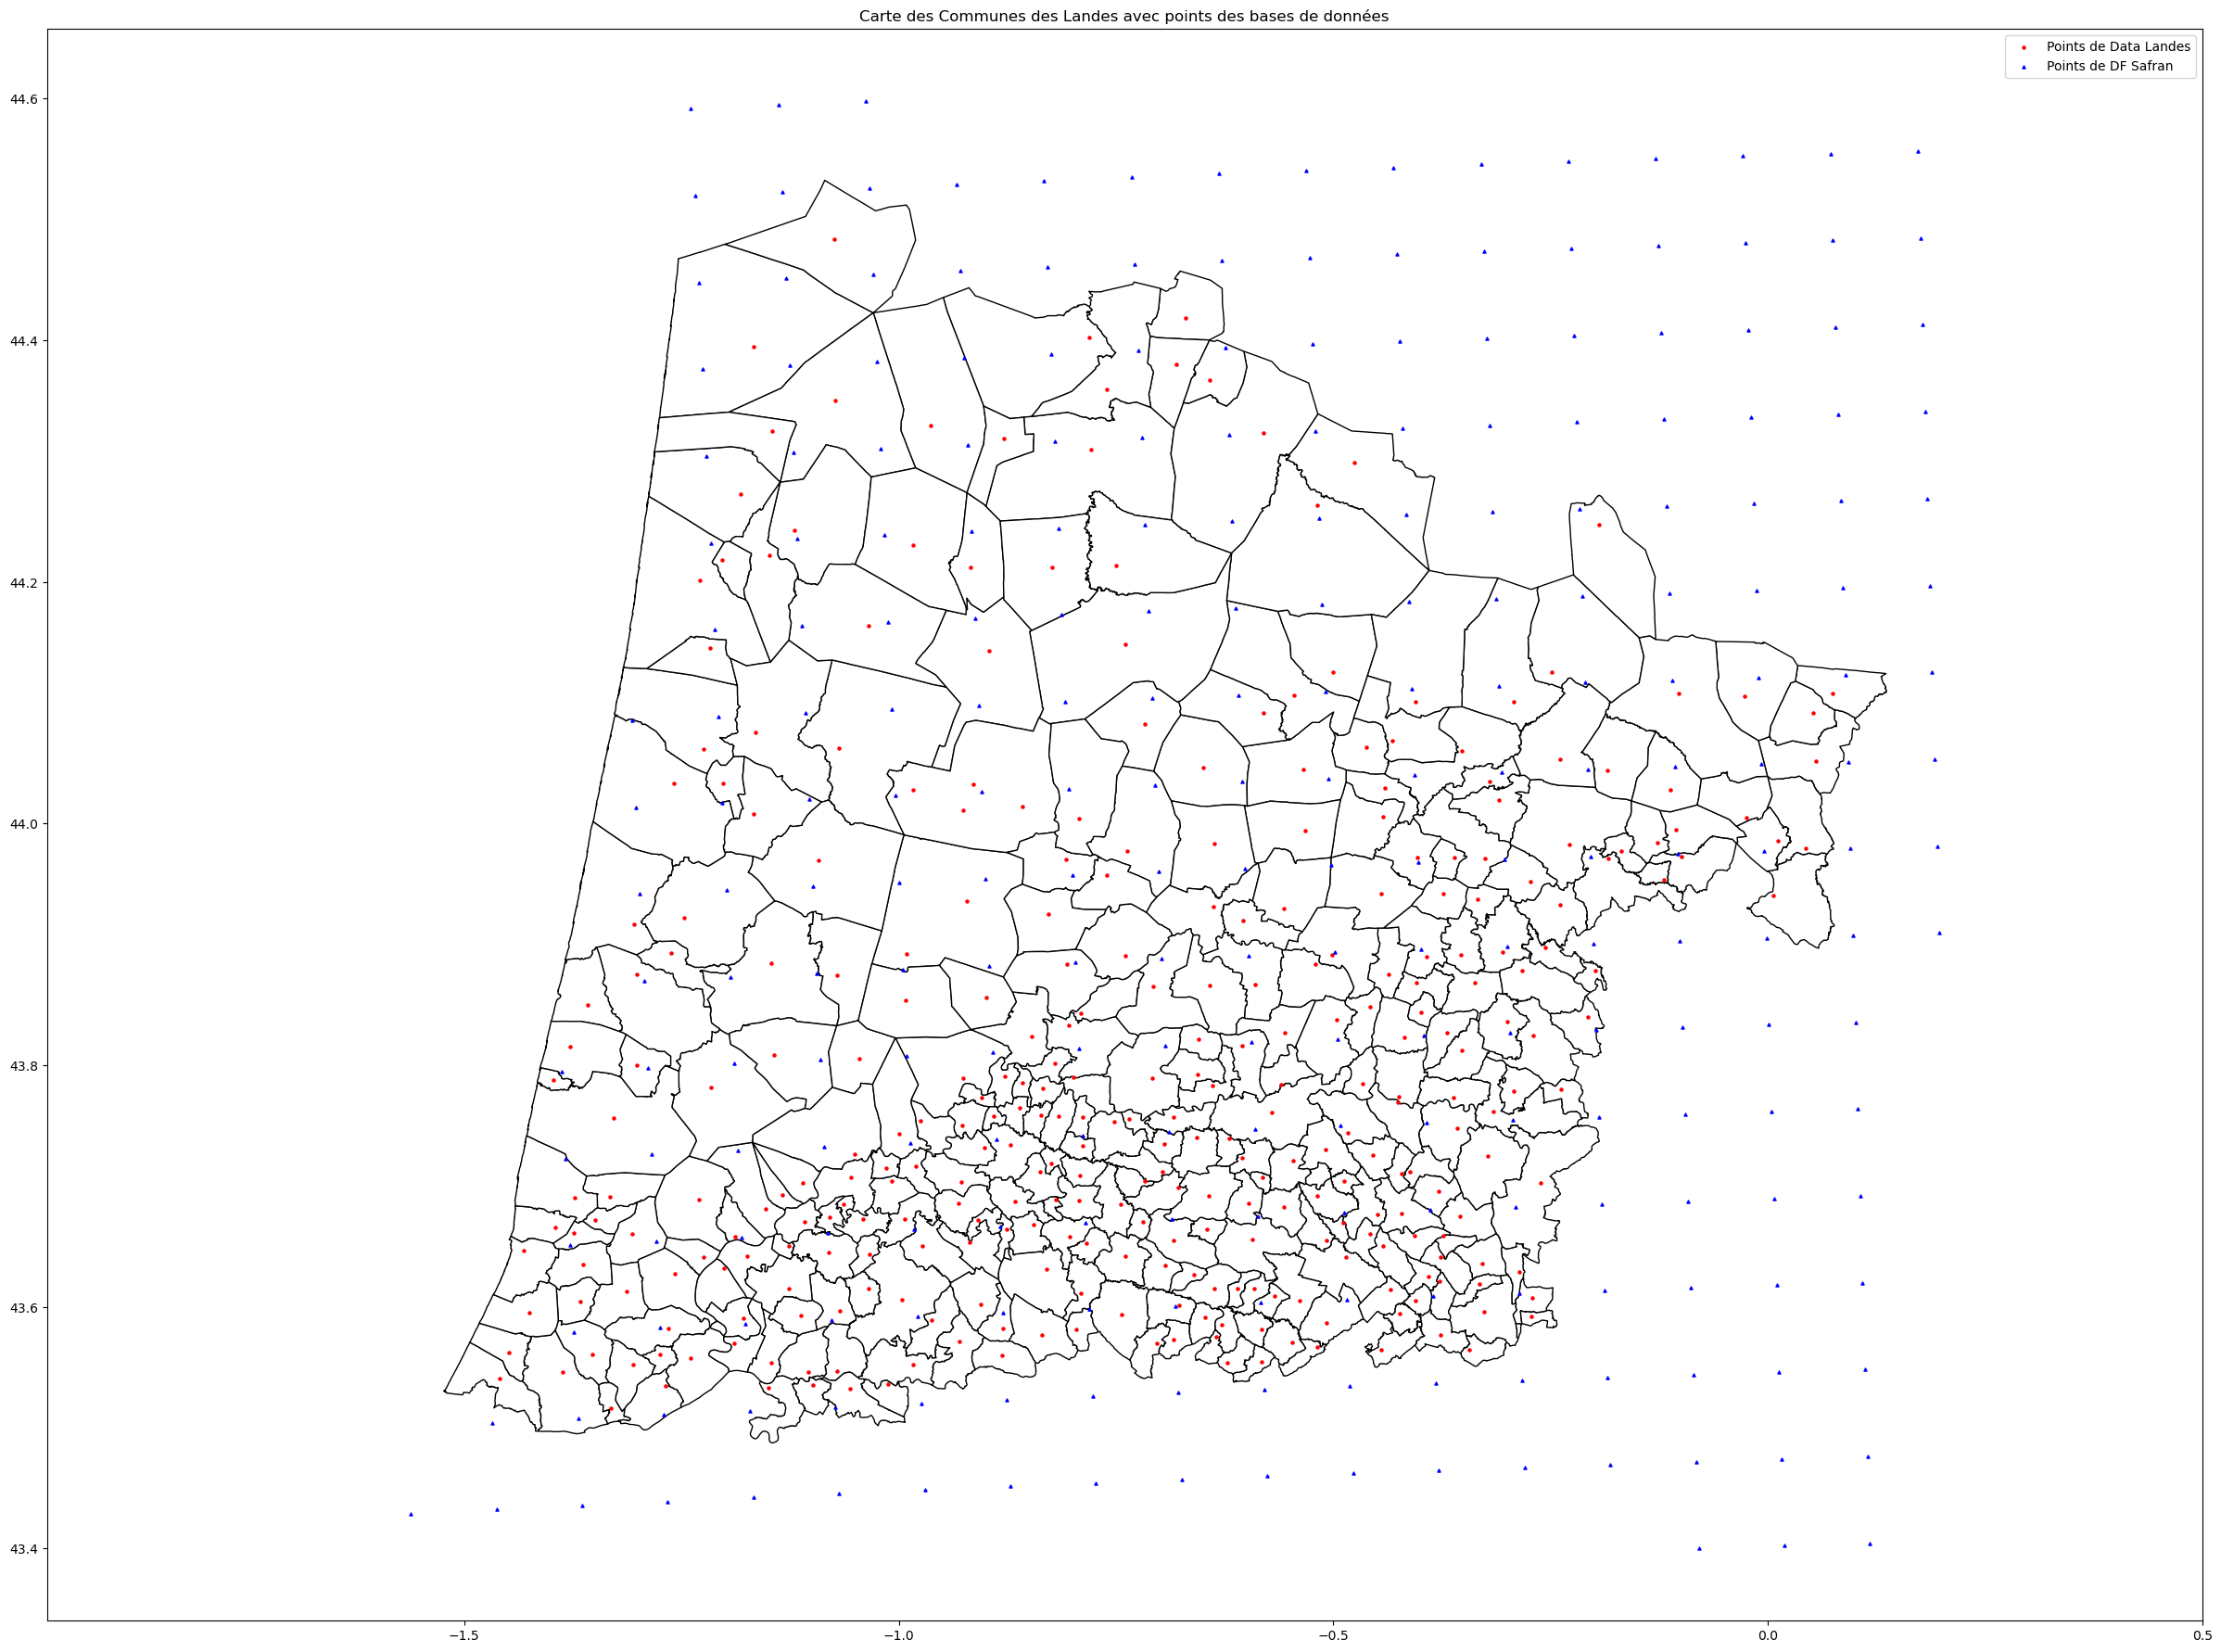

In [15]:
## 5- zoom sur la partie gauche

# Assurer que toutes les données sont dans le même système de coordonnées
geo_data_landes = geo_data_landes.set_crs(epsg=4326)  # WGS 84
geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et geo_df_safran à la carte
geo_data_landes.plot(ax=ax, marker='o', color='red', markersize=5, label='Points de Data Landes')
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

ax.set_xlim(left=None, right=0.5)  

plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()


On remarque que ça ne correspond pas bien.

# 2- Quadrillage des mailles SAFRAN

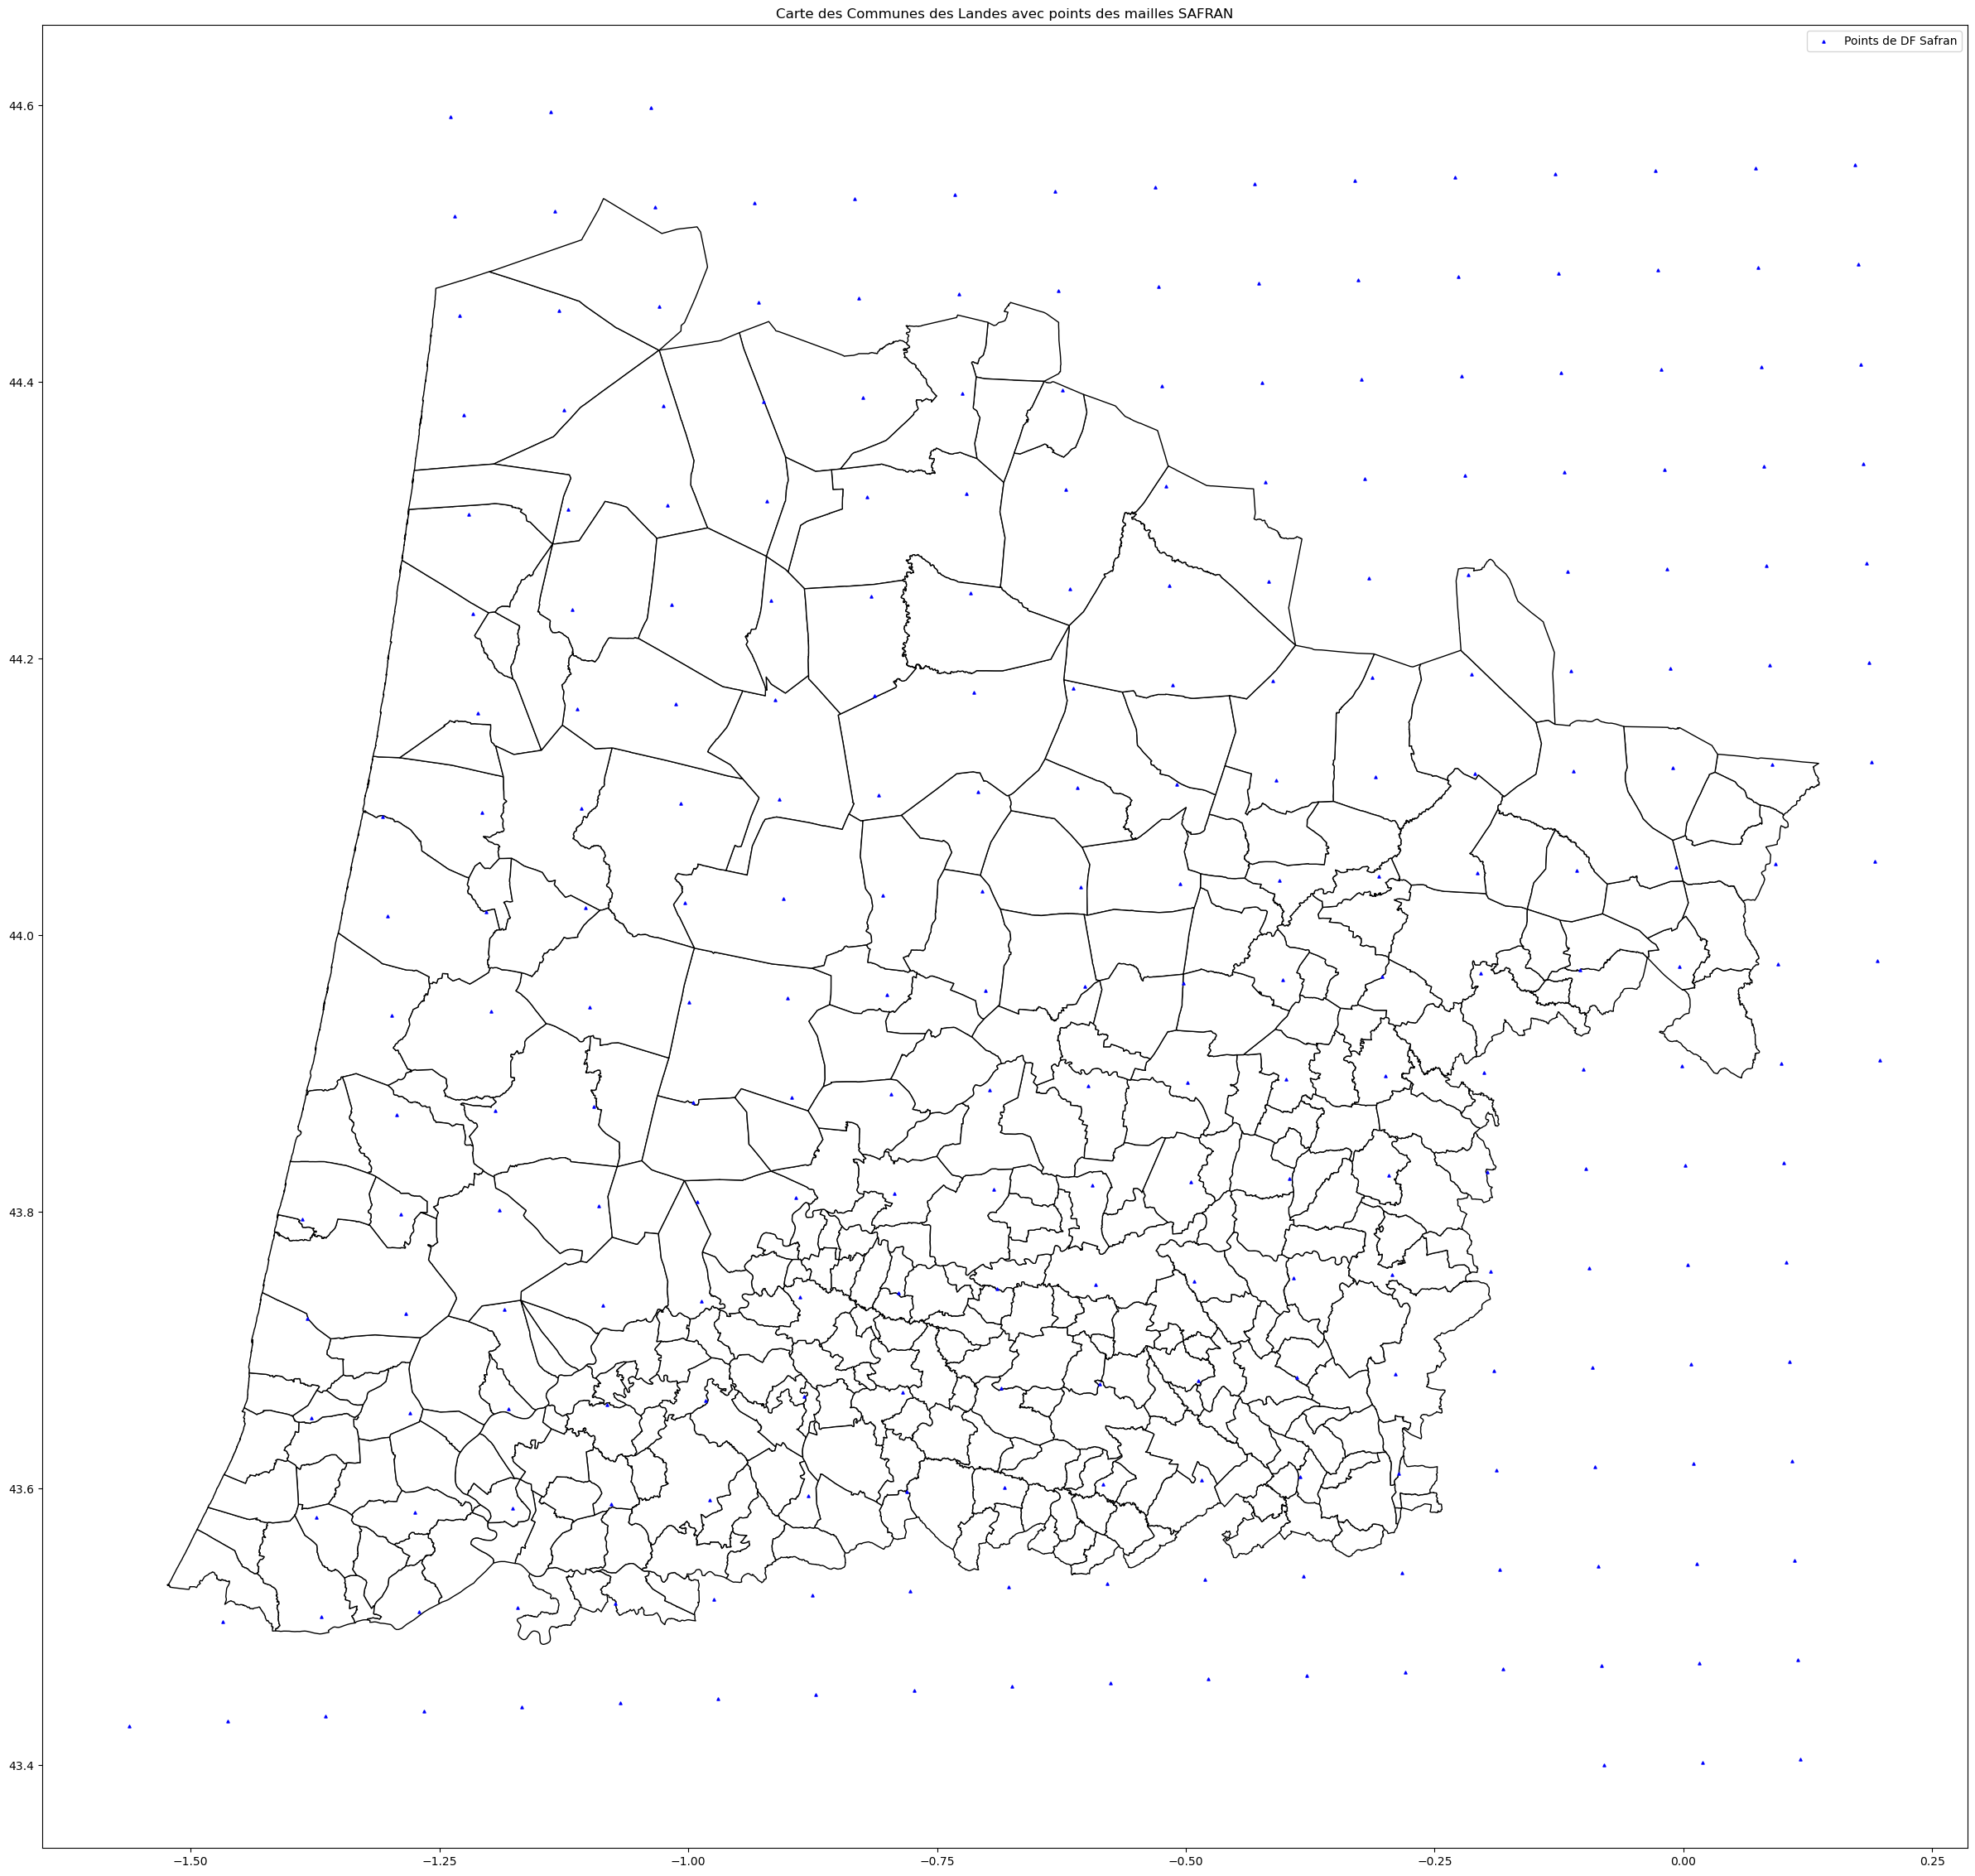

In [16]:
# On reprend le code précédent

geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et à la carte
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

plt.title('Carte des Communes des Landes avec points des mailles SAFRAN')
plt.legend()

plt.show()

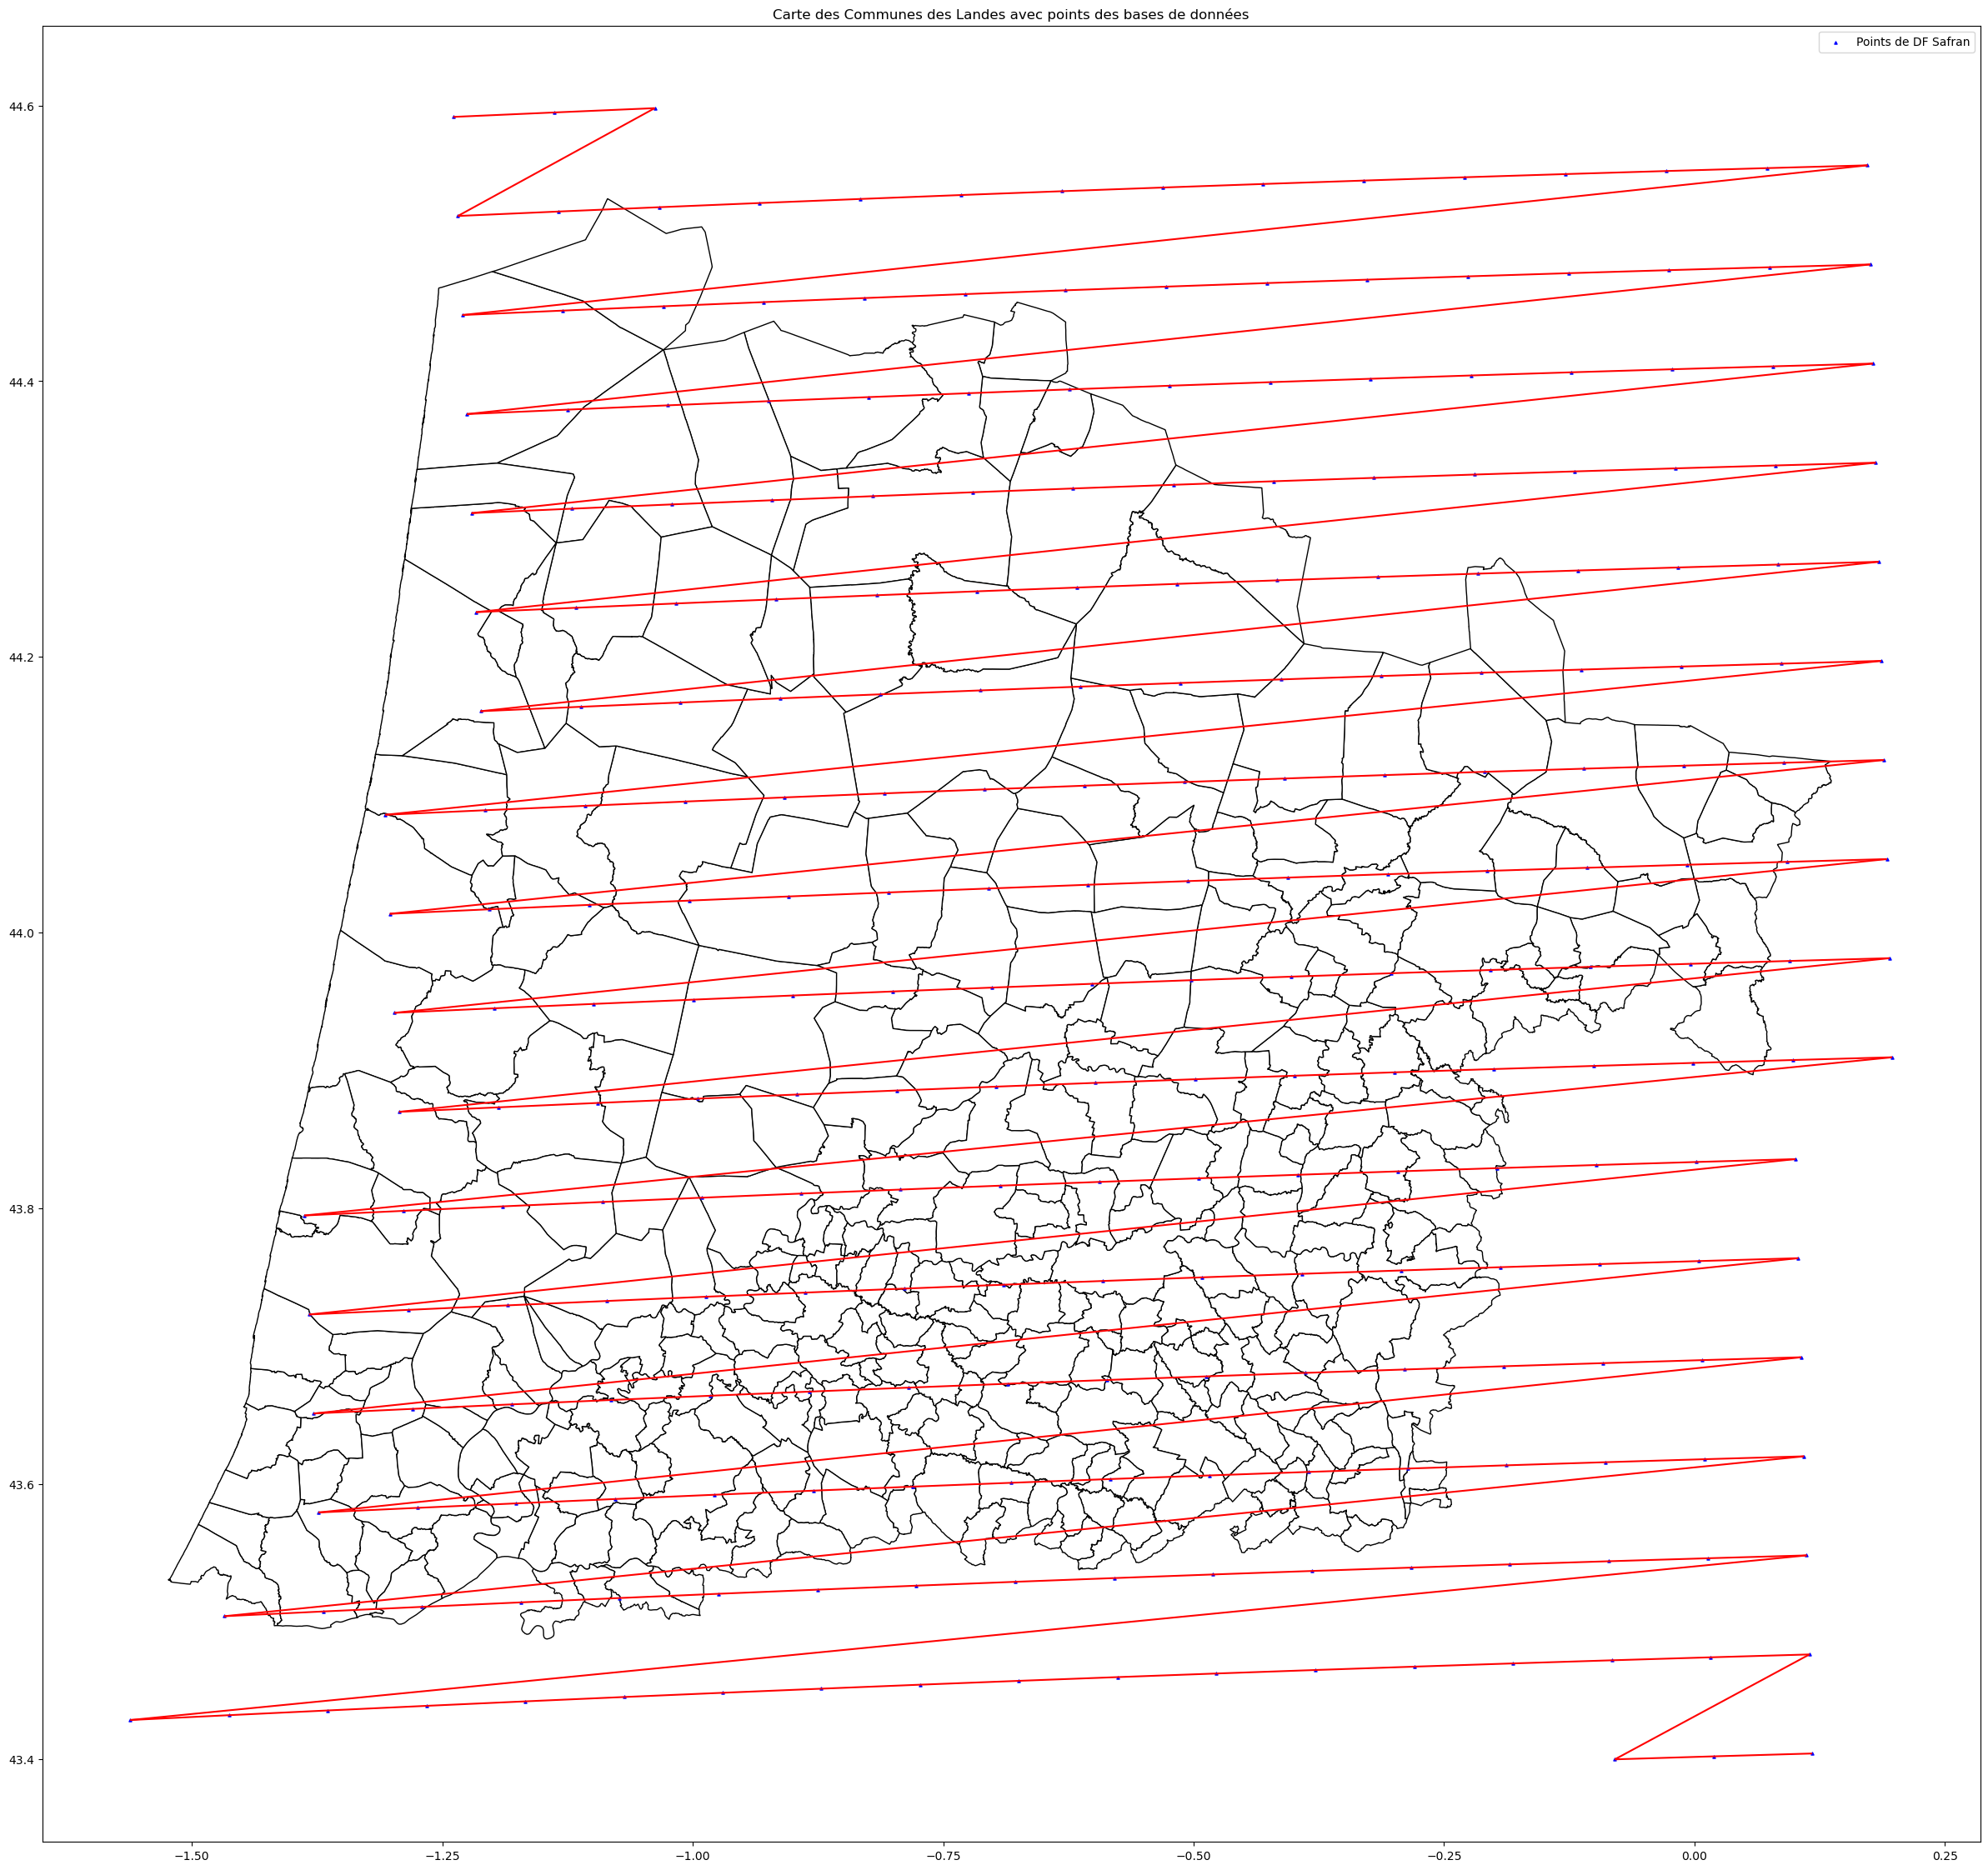

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Création d'un GeoDataFrame à partir de vos points SAFRAN

geometry_safran = [Point(xy) for xy in zip(df_safran['longitude'], df_safran['latitude'])]
geo_df_safran = gpd.GeoDataFrame(df_safran, geometry=geometry_safran)

geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et à la carte
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

# Connecter les points adjacents pour former un quadrillage
for i in range(len(geometry_safran)-1):
    # Assurez-vous de connecter logiquement les points, peut-être par proximité ou par un autre critère
    line = LineString([geometry_safran[i], geometry_safran[i+1]])
    gpd.GeoSeries([line], crs="EPSG:4326").plot(ax=ax, color='red')


plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()

##MOCHE, on reprends ça après dans le code

# 3- Test de jointure des mailles SAFRAN aux communes

On va essayer d'associer à chaque point une commune, afin de pouvoir l'appliquer aux points des mailles SAFRAN

In [18]:
## On efffectue une jointure spatiale des data frame. A chaque point de la maille safran, déterminé par sa latitude 
##et longitude, on associe spatialement la commune dans laquelle il est (INSEE_COM)
## c'est à dire que tous les points de coordonnées des mailles sont associés à une seule commune, et une commune
## peut être associée à plusieurs maille

joined_data = gpd.sjoin(geo_df_safran, communes_landes, how="inner", op='intersects')
print(joined_data.head())


    Unnamed: 0  maille_safran  maille_drias   latitude  longitude  altitude  \
18        6585           7741          5895  44.447977  -1.229972        28   
19        6586           7742          5896  44.451195  -1.129639        23   
20        6587           7743          5897  44.454322  -1.029295        36   
33        6666           7823          5752  44.376109  -1.225422        28   
34        6667           7824          5753  44.379323  -1.125217        32   

    departement region_avant_2016          region2016          nature  ...  \
18  40 - Landes         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
19  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
20  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
33  40 - Landes         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
34  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   

    INSEE_COM          STATUT  POPULATION  INSEE_CAN  IN

/opt/mamba/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [19]:
# Dictionnaire où chaque clé est un code INSEE et chaque valeur est une liste de mailles avec leurs coordonnées
communes_to_mailles = {}

for insee, group in joined_data.groupby('INSEE_COM'):
    # Stocker les mailles et leurs coordonnées dans une liste de dictionnaires
    mailles_info = group.apply(lambda row: {'maille_safran': row['maille_safran'], 'longitude': row['longitude'], 'latitude': row['latitude']}, axis=1).tolist()
    communes_to_mailles[insee] = mailles_info

# Afficher un exemple du dictionnaire
for key, value in communes_to_mailles.items():
    print(f"Commune INSEE: {key}, Mailles: {value}")



Commune INSEE: 40001, Mailles: [{'maille_safran': 8727, 'longitude': -0.289658685061804, 'latitude': 43.6828913046202}]
Commune INSEE: 40004, Mailles: [{'maille_safran': 8716, 'longitude': -1.3784077336823, 'latitude': 43.6509833834393}]
Commune INSEE: 40006, Mailles: [{'maille_safran': 8268, 'longitude': -0.804488143667384, 'latitude': 44.029040480682}]
Commune INSEE: 40008, Mailles: [{'maille_safran': 7829, 'longitude': -0.624024507843836, 'latitude': 44.3940197056465}]
Commune INSEE: 40011, Mailles: [{'maille_safran': 8810, 'longitude': -0.780766866853246, 'latitude': 43.5978965095434}]
Commune INSEE: 40014, Mailles: [{'maille_safran': 8272, 'longitude': -0.405971023623398, 'latitude': 44.0398094711338}]
Commune INSEE: 40015, Mailles: [{'maille_safran': 8186, 'longitude': 0.0895181949722063, 'latitude': 44.1231176609089}]
Commune INSEE: 40020, Mailles: [{'maille_safran': 8544, 'longitude': -0.594096211807855, 'latitude': 43.8189980117494}]
Commune INSEE: 40021, Mailles: [{'maille_sa

*Vérification qu'on a bien toutes les communes des Landes dans ce dictionnaire car j'ai un doute*

In [20]:
# Liste des codes INSEE des communes des Landes
codes_insee_communes = set(communes_landes['INSEE_COM'].unique())
print(f"Nombre de communes dans le GeoDataFrame : {len(codes_insee_communes)}")

# Clés du dictionnaire qui sont les codes INSEE
codes_insee_dict = set(communes_to_mailles.keys())
print(f"Nombre de communes dans le dictionnaire : {len(codes_insee_dict)}")

# Vérifier si des codes INSEE sont manquants dans le dictionnaire
missing_insee = codes_insee_communes.difference(codes_insee_dict)
print(f"Codes INSEE manquants dans le dictionnaire : {missing_insee}")

# Vérifier si des codes sont présents dans le dictionnaire mais pas dans le GeoDataFrame (improbable mais pour exhaustivité)
extra_insee = codes_insee_dict.difference(codes_insee_communes)
print(f"Codes INSEE présents dans le dictionnaire mais pas dans les données des communes : {extra_insee}")


Nombre de communes dans le GeoDataFrame : 327
Nombre de communes dans le dictionnaire : 114
Codes INSEE manquants dans le dictionnaire : {'40298', '40213', '40074', '40023', '40148', '40254', '40065', '40178', '40017', '40201', '40069', '40194', '40100', '40139', '40278', '40265', '40276', '40251', '40205', '40297', '40138', '40306', '40179', '40071', '40033', '40271', '40057', '40005', '40292', '40320', '40143', '40137', '40263', '40026', '40170', '40126', '40058', '40277', '40325', '40109', '40212', '40039', '40099', '40237', '40122', '40301', '40281', '40044', '40290', '40232', '40208', '40064', '40252', '40108', '40311', '40028', '40055', '40214', '40285', '40190', '40007', '40321', '40314', '40140', '40220', '40226', '40328', '40228', '40050', '40076', '40077', '40073', '40193', '40103', '40188', '40291', '40038', '40084', '40327', '40070', '40308', '40151', '40174', '40261', '40127', '40255', '40274', '40117', '40209', '40142', '40088', '40275', '40101', '40042', '40113', '40068'

/tmp/ipykernel_384/1584419430.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


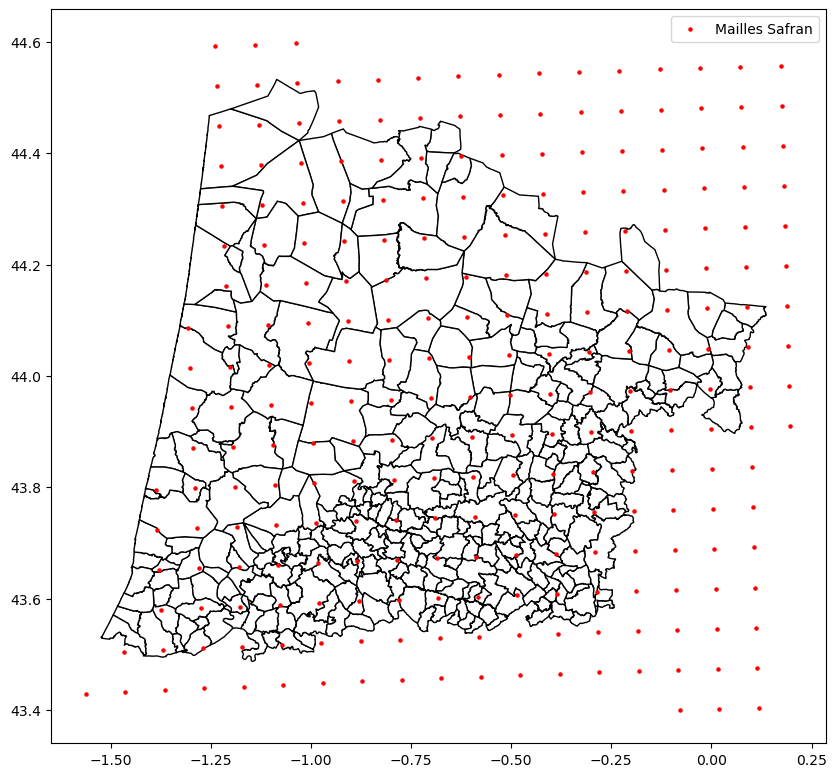

In [21]:
## pour vérifier d'ou vient le problème

fig, ax = plt.subplots(figsize=(10, 10))
communes_landes.plot(ax=ax, color='white', edgecolor='black', label='Communes')
geo_df_safran.plot(ax=ax, color='red', marker='o', markersize=5, label='Mailles Safran')
plt.legend()
plt.show()


*Il nous manque des communes car on n'a regardé que les coins des mailles et pas la maille en tant que carré*

/tmp/ipykernel_384/3887940614.py:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


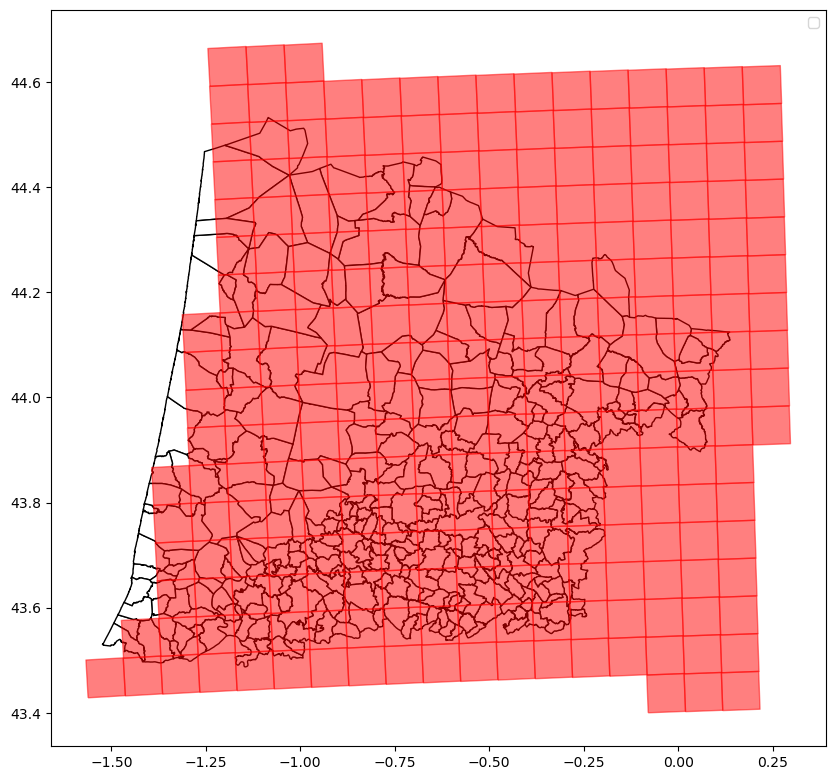

In [22]:
##1- on créé les polygones correspondant aux mailles safran, et on vérifie sur une carte

# Convertir les points en coordonnées projetées (Lambert 93 par exemple)
geo_df_safran['geometry'] = [Point(xy) for xy in zip(geo_df_safran.longitude, geo_df_safran.latitude)]
geo_df_safran = gpd.GeoDataFrame(geo_df_safran, crs='EPSG:4326')  # Assurez-vous que le CRS est WGS84
geo_df_safran = geo_df_safran.to_crs(epsg=2154)  # Reprojection en Lambert 93

# Fonction pour créer un polygone de maille à partir d'un point (coin inférieur gauche)
def create_square(point, size):
    return Polygon([
        (point.x, point.y),
        (point.x + size, point.y),
        (point.x + size, point.y + size),
        (point.x, point.y + size),
        (point.x, point.y)  # Fermeture du polygone
    ])

# Taille de la maille SAFRAN en mètres
size = 8000  # 8 km

# Création des polygones de maille SAFRAN
geo_df_safran['geometry'] = geo_df_safran.apply(lambda row: create_square(row.geometry, size), axis=1)
mailles_polygons = geo_df_safran.copy()

# Reprojection des polygones en coordonnées géographiques pour visualisation
mailles_polygons = mailles_polygons.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
communes_landes.to_crs(epsg=4326).plot(ax=ax, color='white', edgecolor='black', label='Communes')
mailles_polygons.plot(ax=ax, color='red', alpha=0.5, edgecolor='red', label='Mailles Safran')
plt.legend()
plt.show()


In [23]:
##2- On fait la jointure avec les polygones

communes_landes = communes_landes.to_crs(epsg=2154)
mailles_polygons = mailles_polygons.to_crs(epsg=2154)

print("CRS de communes_landes:", communes_landes.crs)
print("CRS de mailles_polygons:", mailles_polygons.crs)

joined_data = gpd.sjoin(communes_landes, mailles_polygons, how="inner", predicate='intersects')
print(joined_data)


CRS de communes_landes: EPSG:2154
CRS de mailles_polygons: EPSG:2154
                           id    ID                      NOM  \
0    COMMUNE_0000000009758658  None     Labastide-d'Armagnac   
0    COMMUNE_0000000009758658  None     Labastide-d'Armagnac   
0    COMMUNE_0000000009758658  None     Labastide-d'Armagnac   
0    COMMUNE_0000000009758658  None     Labastide-d'Armagnac   
0    COMMUNE_0000000009758658  None     Labastide-d'Armagnac   
..                        ...   ...                      ...   
325  COMMUNE_0000000009758442  None                Roquefort   
325  COMMUNE_0000000009758442  None                Roquefort   
325  COMMUNE_0000000009758442  None                Roquefort   
326  COMMUNE_0000000009758654  None  Saint-Julien-d'Armagnac   
326  COMMUNE_0000000009758654  None  Saint-Julien-d'Armagnac   

                       NOM_M INSEE_COM          STATUT  POPULATION INSEE_CAN  \
0       LABASTIDE-D'ARMAGNAC     40131  Commune simple         691        08   
0 

In [24]:
##3- dico

commune_mailles_dict = {}

for name, group in joined_data.groupby('INSEE_COM'):
    mailles_list = group['maille_safran'].tolist()
    commune_mailles_dict[name] = mailles_list

# Dictionnaire avec le code INSEE de chaque commune et les mailles SAFRAN associées
print(commune_mailles_dict)


{'40001': [8815, 8814, 8727, 8726], '40002': [8810, 8899, 8809], '40003': [8718, 8628], '40004': [8804, 8716], '40005': [8902, 8813], '40006': [8359, 8267, 8360, 8268], '40007': [8900], '40008': [7912, 7911, 7829, 7828], '40011': [8810, 8899, 8898, 8809], '40012': [8546, 8545], '40013': [8547, 8456], '40014': [8364, 8363, 8273, 8272, 8271], '40015': [8277, 8276, 8186, 8185], '40016': [8812, 8813], '40017': [8724, 8723], '40018': [8631, 8541], '40019': [8082, 7991], '40020': [8634, 8633, 8544, 8543], '40021': [8627, 8626, 8537, 8536], '40022': [8814, 8726], '40023': [8722, 8721], '40024': [8723, 8633], '40025': [8636, 8635, 8546, 8545], '40026': [8634], '40027': [8900], '40028': [8810, 8809], '40029': [8812, 8813], '40030': [8276], '40031': [8631, 8541, 8540], '40032': [7911, 7828], '40033': [8271], '40034': [8895, 8806], '40035': [8807], '40036': [8804, 8716], '40037': [8634, 8544, 8635, 8545], '40038': [8810, 8722], '40039': [8457, 8366], '40040': [8451, 8450], '40041': [8900], '40042

In [25]:
##On vérifie qu'on a bien toutes les communes

# Liste des codes INSEE des communes des Landes
codes_insee_communes = set(communes_landes['INSEE_COM'].unique())
print(f"Nombre de communes dans le GeoDataFrame : {len(codes_insee_communes)}")

# Clés du dictionnaire qui sont les codes INSEE
codes_insee_dict = set(commune_mailles_dict.keys())
print(f"Nombre de communes dans le dictionnaire : {len(codes_insee_dict)}")

# Vérifier si des codes INSEE sont manquants dans le dictionnaire
missing_insee = codes_insee_communes.difference(codes_insee_dict)
print(f"Codes INSEE manquants dans le dictionnaire : {missing_insee}")

# Vérifier si des codes sont présents dans le dictionnaire mais pas dans le GeoDataFrame (improbable mais pour exhaustivité)
extra_insee = codes_insee_dict.difference(codes_insee_communes)
print(f"Codes INSEE présents dans le dictionnaire mais pas dans les données des communes : {extra_insee}")


Nombre de communes dans le GeoDataFrame : 327
Nombre de communes dans le dictionnaire : 326
Codes INSEE manquants dans le dictionnaire : {'40065'}
Codes INSEE présents dans le dictionnaire mais pas dans les données des communes : set()


*Il faudra mettre à la main celle restante car elle est sur la côte donc hors maille*

In [26]:
cpbt = pd.read_csv('combine.csv', sep =';')
cap = cpbt[cpbt['Code INSEE'] == '40065']
cap

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Origine de l'alerte,Moyens de première intervention,Surface parcourue (m2),Surface forêt (m2),...,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Hygrométrie (%),Vitesse moyenne du vent (Km/h),Direction du vent,Température (°C),Précision de la donnée,Présence d'un contour valide
8539,2009,4483,40,40065,Capbreton,24/04/2009 17:34,Indéterminé,NaN,1000,1000.0,...,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Non,"
14126,2011,4140,40,40065,Capbreton,30/06/2011 13:21,Indéterminé,NaN,4000,4000.0,...,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Non,"
14134,2011,4150,40,40065,Capbreton,26/06/2011 00:10,Indéterminé,NaN,40000,40000.0,...,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Non,"
14137,2011,4154,40,40065,Capbreton,25/06/2011 12:44,Indéterminé,NaN,10000,10000.0,...,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Non,"
14161,2011,4196,40,40065,Capbreton,11/05/2011 16:28,Indéterminé,NaN,100,100.0,...,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Non,"
29199,2017,3002,40,40065,Capbreton,11/06/2017 17:20,Indéterminé,NaN,1000,0.0,...,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Non,"
43563,2022,10818,40,40065,Capbreton,04/03/2022 09:17,Indéterminé,NaN,4,4.0,...,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Non,"


*La question se pose à propos de CapBretton, cette commune étant la seule qui se retrouve complètement hors du maillage Safran, commune dans laquelle pourtant il y a eu 7 feux entre 2006 et 2022...*

# 4 - Jointure de Y et de la base des communes/mailles

L'idée est tout simplement de regrouper les deux bases que l'on a trouvées précédemment pour se retrouver avec une base Maille par années/Feux en été

In [27]:
# Convertir le dictionnaire en DataFrame
df = pd.DataFrame.from_dict(commune_mailles_dict, orient='index')

df_stacked = df.stack().reset_index(level=1, drop=True).reset_index()

# Afficher le DataFrame
print(df)

          0       1       2       3       4       5       6   7   8
40001  8815  8814.0  8727.0  8726.0     NaN     NaN     NaN NaN NaN
40002  8810  8899.0  8809.0     NaN     NaN     NaN     NaN NaN NaN
40003  8718  8628.0     NaN     NaN     NaN     NaN     NaN NaN NaN
40004  8804  8716.0     NaN     NaN     NaN     NaN     NaN NaN NaN
40005  8902  8813.0     NaN     NaN     NaN     NaN     NaN NaN NaN
...     ...     ...     ...     ...     ...     ...     ...  ..  ..
40330  8451  8450.0  8359.0  8360.0     NaN     NaN     NaN NaN NaN
40331  8547  8546.0  8456.0  8455.0     NaN     NaN     NaN NaN NaN
40332  7994  7993.0  7909.0  7908.0  7826.0  7825.0  7824.0 NaN NaN
40333  8452  8451.0  8361.0  8360.0  8269.0  8268.0     NaN NaN NaN
40334  8719     NaN     NaN     NaN     NaN     NaN     NaN NaN NaN

[326 rows x 9 columns]


In [28]:
# Sélectionner toutes les colonnes sauf la première
colonnes_a_fusionner = df.columns[0:]

# Créer une nouvelle colonne contenant des listes des valeurs des colonnes à fusionner
df['Mailles'] = df[colonnes_a_fusionner].apply(lambda x: x.tolist(), axis=1)

# Supprimer les colonnes fusionnées
df.drop(colonnes_a_fusionner, axis=1, inplace=True)

# Utilisez une fonction lambda avec apply pour enlever les NaN de chaque liste
df['Mailles'] = df['Mailles'].apply(lambda x: [val for val in x if pd.notna(val)])

# Déplacer l'index dans une colonne à part entière avec un nom spécifié
df.reset_index(inplace=True)

df.rename(columns={'index': 'Code INSEE'}, inplace=True)

# Afficher le DataFrame résultant
df

,Code INSEE,Mailles
0,40001,"[8815.0, 8814.0, 8727.0, 8726.0]"
1,40002,"[8810.0, 8899.0, 8809.0]"
2,40003,"[8718.0, 8628.0]"
3,40004,"[8804.0, 8716.0]"
4,40005,"[8902.0, 8813.0]"
...,...,...
321,40330,"[8451.0, 8450.0, 8359.0, 8360.0]"
322,40331,"[8547.0, 8546.0, 8456.0, 8455.0]"
323,40332,"[7994.0, 7993.0, 7909.0, 7908.0, 7826.0, 7825...."
324,40333,"[8452.0, 8451.0, 8361.0, 8360.0, 8269.0, 8268.0]"


In [29]:
# Renommer une colonne dans un DataFrame pandas
df_stacked.rename(columns={'index': 'Code INSEE'}, inplace=True)
df_stacked.rename(columns={0: 'Maille'}, inplace=True)
df_stacked

,Code INSEE,Maille
0,40001,8815.0
1,40001,8814.0
2,40001,8727.0
3,40001,8726.0
4,40002,8810.0
...,...,...
967,40333,8361.0
968,40333,8360.0
969,40333,8269.0
970,40333,8268.0


In [30]:
dfeu = pd.read_csv('feux_par_communes.csv')
dfeu

,Code INSEE,Feu en été,Année
0,4001,0,2006
1,4004,0,2006
2,4005,0,2006
3,4006,0,2006
4,4007,0,2006
...,...,...,...
6948,40330,0,2022
6949,40331,1,2022
6950,40332,1,2022
6951,40333,0,2022


In [31]:
# On récupère un dataframe avec pour chaque commune par année si elle a été victime d'un feu ou non
feux = dfeu.pivot(index='Code INSEE', columns='Année', values='Feu en été')
feux

Année,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Code INSEE,,,,,,,,,,,,,,,,,
4001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40330,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
40331,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
40332,1,1,1,1,1,0,1,1,0,1,0,1,0,1,1,0,1


In [32]:
# Convertir le type de données d'une colonne
df['Code INSEE'] = df['Code INSEE'].astype(int)


In [33]:
# Fusionnez les deux DataFrames sur la variable commune 'Code INSEE'
testfeux = pd.merge(df, feux, on='Code INSEE', how='left')
testfeux

,Code INSEE,Mailles,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,40001,"[8815.0, 8814.0, 8727.0, 8726.0]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40002,"[8810.0, 8899.0, 8809.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40003,"[8718.0, 8628.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40004,"[8804.0, 8716.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40005,"[8902.0, 8813.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,40330,"[8451.0, 8450.0, 8359.0, 8360.0]",0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
322,40331,"[8547.0, 8546.0, 8456.0, 8455.0]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
323,40332,"[7994.0, 7993.0, 7909.0, 7908.0, 7826.0, 7825....",1,1,1,1,1,0,1,1,0,1,0,1,0,1,1,0,1
324,40333,"[8452.0, 8451.0, 8361.0, 8360.0, 8269.0, 8268.0]",0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0


Il faudrait peut être vérifier que la fusion s'est bien passé et que le nombre de lignes correspondait bien (il me semble que ce n'était pas le cas avant mais je pense que c'est ok)

In [34]:
# On explose les lignes par rapport aux différentes mailles
# Utiliser explode pour séparer les listes et "dupliquer" les lignes
exp = testfeux.explode('Mailles')

# Réinitialiser l'index si nécessaire
exp.reset_index(drop=True, inplace=True)

# Afficher le DataFrame résultant
exp


,Code INSEE,Mailles,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,40001,8815.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40001,8814.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40001,8727.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40001,8726.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40002,8810.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,40333,8361.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0
968,40333,8360.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0
969,40333,8269.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0
970,40333,8268.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0


In [35]:
# On group by mailles
# Sommer uniquement certaines colonnes pour chaque groupe
groupes = exp.groupby('Mailles')[[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]].sum()

# Afficher le résultat
groupes


,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Mailles,,,,,,,,,,,,,,,,,
7660.0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,1,0,1
7741.0,2,2,2,2,2,2,2,1,1,2,0,1,0,2,2,1,2
7742.0,2,2,2,2,2,2,2,1,1,2,0,1,0,2,2,1,2
7743.0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,1,0,1
7823.0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8980.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8981.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8982.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
groupes.reset_index(inplace=True)
groupes.rename(columns={'index': 'Mailles'}, inplace=True)
groupes


,Mailles,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,7660.0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,1,0,1
1,7741.0,2,2,2,2,2,2,2,1,1,2,0,1,0,2,2,1,2
2,7742.0,2,2,2,2,2,2,2,1,1,2,0,1,0,2,2,1,2
3,7743.0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,1,0,1
4,7823.0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,8980.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
164,8981.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
165,8982.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
166,8983.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Pour finir on passe en binaire (0 il n'y a pas ue de feux, 1 il y a eu au moins 1 feu)

In [37]:
groupes.dtypes

Mailles    float64
2006         int64
2007         int64
2008         int64
2009         int64
2010         int64
2011         int64
2012         int64
2013         int64
2014         int64
2015         int64
2016         int64
2017         int64
2018         int64
2019         int64
2020         int64
2021         int64
2022         int64
dtype: object

In [38]:
print(groupes.columns)


Index(['Mailles',      2006,      2007,      2008,      2009,      2010,
            2011,      2012,      2013,      2014,      2015,      2016,
            2017,      2018,      2019,      2020,      2021,      2022],
      dtype='object')


In [39]:
# Sélectionner les noms des colonnes à transformer (qui sont des années ici)
colonnes_a_transformer = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022]

# Appliquer la transformation directement sur les colonnes existantes
for annee in colonnes_a_transformer:
    groupes[annee] = groupes[annee].apply(lambda x: 1 if x > 0 else 0)

# Afficher les premières lignes du DataFrame pour vérifier les modifications
print(groupes)


     Mailles  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  \
0     7660.0     1     1     1     1     1     1     1     0     0     1   
1     7741.0     1     1     1     1     1     1     1     1     1     1   
2     7742.0     1     1     1     1     1     1     1     1     1     1   
3     7743.0     1     1     1     1     1     1     1     0     0     1   
4     7823.0     1     1     1     1     1     1     1     1     1     1   
..       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
163   8980.0     1     0     0     0     0     0     1     0     0     0   
164   8981.0     0     0     0     0     0     0     1     0     0     0   
165   8982.0     0     0     0     0     0     0     0     0     0     0   
166   8983.0     0     0     0     0     0     0     0     0     0     0   
167   8984.0     0     0     0     0     0     0     0     0     0     0   

     2016  2017  2018  2019  2020  2021  2022  
0       0     0     0     1     1     0

In [87]:
# Utiliser melt pour restructurer le DataFrame
groupes_melted = pd.melt(groupes, id_vars='Mailles', var_name='Année', value_name='Feu en été')
print(groupes_melted)


      Mailles Année  Feu en été
0      7660.0  2006           1
1      7741.0  2006           1
2      7742.0  2006           1
3      7743.0  2006           1
4      7823.0  2006           1
...       ...   ...         ...
2851   8980.0  2022           0
2852   8981.0  2022           0
2853   8982.0  2022           0
2854   8983.0  2022           0
2855   8984.0  2022           0

[2856 rows x 3 columns]


In [93]:
groupes_melted.to_csv('Y.csv', index=False)

## Tableau correspondant au X

Maintenant qu'on a notre vecteur Y, il faut faire notre tableau de X, de la forme suivante :

*Numéro de maille*  / *Tous les jours de l'été*

     ...            IFM du jour

Ce tableau est à faire soit par année comme pour le Y, soit en ligne (à déterminer). Pour l'instant, on va faire comme le Y.


In [40]:
#1- Upload de la base des IFM

### UPLOAD LE FICHIER AVANT ###

# Initialiser une liste vide pour stocker les données
data = []

# Ouvrir le fichier texte pour la lecture
with open('ifm donnees 2022 rcp4.5.txt', 'r') as file:
    for line in file:
        # Ignorer les lignes de commentaire
        if not line.startswith('#'):
            # Diviser la ligne pour obtenir les différentes valeurs
            columns = line.strip().split(';')
            # Ajouter les valeurs à la liste de données
            data.append(columns)

# Créer un DataFrame à partir de la liste de données
df_ifm45 = pd.DataFrame(data, columns=['Date', 'Latitude', 'Longitude', 'ifm', 'ifm-max'])

# Convertir les colonnes de données en types appropriés
df_ifm45['Date'] = pd.to_datetime(df_ifm45['Date'], format='%Y%m%d')
df_ifm45['Latitude'] = pd.to_numeric(df_ifm45['Latitude'])
df_ifm45['Longitude'] = pd.to_numeric(df_ifm45['Longitude'])
df_ifm45['ifm'] = pd.to_numeric(df_ifm45['ifm'])
df_ifm45['ifm-max'] = pd.to_numeric(df_ifm45['ifm-max'])

# Afficher les premières lignes du DataFrame pour vérification
print(df_ifm45.head())


        Date  Latitude  Longitude  ifm  ifm-max
0 2006-01-01   43.5074   -1.36829  0.7      0.8
1 2006-01-02   43.5074   -1.36829  0.6      0.7
2 2006-01-03   43.5074   -1.36829  0.6      0.7
3 2006-01-04   43.5074   -1.36829  0.9      0.9
4 2006-01-05   43.5074   -1.36829  0.9      1.0


In [ ]:
#2- On vérifie que la position de ces ifm correspond à ceux de la maille SAFRAN

geometry_ifm = [Point(xy) for xy in zip(df_ifm45['Longitude'], df_ifm45['Latitude'])]
geo_data_ifm = gpd.GeoDataFrame(df_ifm45, geometry=geometry_ifm)

geometry_safran = [Point(xy) for xy in zip(df_safran['longitude'], df_safran['latitude'])]
geo_df_safran = gpd.GeoDataFrame(df_safran, geometry=geometry_safran)


# Assurer que toutes les données sont dans le même système de coordonnées
geo_data_ifm = geo_data_ifm.set_crs(epsg=4326)  # WGS 84
geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et geo_df_safran à la carte
geo_data_ifm.plot(ax=ax, marker='o', color='red', markersize=5, label='Points de Data IFM')
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()

Les deux bases coincident, on va donc pouvoir calculer les IFM comme la moyenne des 4 coins du carré.

*Test pour l'année 2006*


In [ ]:
#2- Merge la base des ifm avec celles des mailles safran pour obtenir notre  vecteur

df_ifm45['Date'] = pd.to_datetime(df_ifm45['Date'])

# Filtrer les données pour la période du 1er juin au 30 août 2006
start_date = pd.to_datetime("2006-06-01")
end_date = pd.to_datetime("2006-08-30")
filtered_ifm = df_ifm45[(df_ifm45['Date'] >= start_date) & (df_ifm45['Date'] <= end_date)]

gdf_ifm = gpd.GeoDataFrame(filtered_ifm, geometry=gpd.points_from_xy(filtered_ifm.Longitude, filtered_ifm.Latitude))
gdf_mailles = gpd.GeoDataFrame(df_safran, geometry=gpd.points_from_xy(df_safran.longitude, df_safran.latitude))

# Reprojection en CRS projeté
gdf_ifm = gdf_ifm.set_crs(epsg=4326).to_crs(epsg=3857)
gdf_mailles = gdf_mailles.set_crs(epsg=4326).to_crs(epsg=3857)

# Appliquer un buffer en mètres
buffer_distance = 500  # 500 mètres
gdf_mailles['geometry'] = gdf_mailles['geometry'].buffer(buffer_distance)

# Utiliser une jointure spatiale avec une tolérance (buffer)
merged_data = gpd.sjoin(gdf_ifm, gdf_mailles, how="inner", predicate='intersects')

grouped = merged_data.groupby(['maille_safran', 'Date'])['ifm'].mean().reset_index()
pivot_table = grouped.pivot(index='maille_safran', columns='Date', values='ifm')
pivot_table.columns = [d.strftime('%d %b') for d in pivot_table.columns]
ifm_moyen = pivot_table.reset_index()
print(ifm_moyen)


Le tableau ci-dessus nous donne l'IFM moyen d'une maille (moyenne des IFM calculés aux 4 coins de la maille). On pourrai aussi comparer en prenant l'IFM max des 4 coins.

*De 2006 à 2022*

In [86]:
ifm_moyen_total = pd.DataFrame()

# Itération sur chaque année de 2006 à 2022
for annee in range(2006, 2023):
    start_date = pd.to_datetime(f"{annee}-06-01")
    end_date = pd.to_datetime(f"{annee}-08-30")
    filtered_ifm = df_ifm45[(df_ifm45['Date'] >= start_date) & (df_ifm45['Date'] <= end_date)]

    gdf_ifm = gpd.GeoDataFrame(filtered_ifm, geometry=gpd.points_from_xy(filtered_ifm.Longitude, filtered_ifm.Latitude))
    gdf_mailles = gpd.GeoDataFrame(df_safran, geometry=gpd.points_from_xy(df_safran.longitude, df_safran.latitude))

    gdf_ifm = gdf_ifm.set_crs(epsg=4326).to_crs(epsg=3857)
    gdf_mailles = gdf_mailles.set_crs(epsg=4326).to_crs(epsg=3857)

    buffer_distance = 500  # en mètres
    gdf_mailles['geometry'] = gdf_mailles['geometry'].buffer(buffer_distance)

    merged_data = gpd.sjoin(gdf_ifm, gdf_mailles, how="inner", predicate='intersects')

    # Groupement et calcul de la moyenne de l'IFM
    grouped = merged_data.groupby(['maille_safran', 'Date'])['ifm'].mean().reset_index()
    pivot_table = grouped.pivot(index='maille_safran', columns='Date', values='ifm')
    pivot_table.columns = [d.strftime('%d %b') for d in pivot_table.columns]
    pivot_table['Année'] = annee
    pivot_table.reset_index(inplace=True)

    ifm_moyen_total = pd.concat([ifm_moyen_total, pivot_table], ignore_index=True)

print(ifm_moyen_total)


      maille_safran  01 Jun  02 Jun  03 Jun  04 Jun  05 Jun  06 Jun  07 Jun  \
0              7741     6.6     4.4     4.5     0.1     0.1     0.0     0.5   
1              7742     8.7     4.8     6.1     0.0     0.0     0.0     0.4   
2              7743     8.0     2.5     2.9     0.0     0.0     0.0     0.3   
3              7823     8.3    10.2     9.3     0.0     0.0     0.0     0.5   
4              7824     7.8     6.5     7.4     0.0     0.0     0.0     0.4   
...             ...     ...     ...     ...     ...     ...     ...     ...   
2443           8814     5.2     0.3     3.0     0.9     0.9     0.9     6.2   
2444           8815     3.6     0.3     2.1     0.5     0.4     0.2     2.5   
2445           8893     5.4     5.0    13.0     6.8     8.4     7.8    11.8   
2446           8894     6.3     5.2    12.1     7.6     9.6     7.6    14.0   
2447           8896    10.6     5.5    11.4     5.3     5.4     4.1     8.8   

      08 Jun  09 Jun  ...  22 Aug  23 Aug  24 Aug  

In [91]:
ifm_moyen_total.to_csv('X.csv', index=False)

## Tableau X avec les IFM projeté (2022 à 2100)

Il faut faire tourner le code pour le X normal avant car on reprend le début du code

In [42]:
ifm_moyen_projete = pd.DataFrame()

# Itération sur chaque année de 2006 à 2022
for annee in range(2022, 2101):
    start_date = pd.to_datetime(f"{annee}-06-01")
    end_date = pd.to_datetime(f"{annee}-08-30")
    filtered_ifm = df_ifm45[(df_ifm45['Date'] >= start_date) & (df_ifm45['Date'] <= end_date)]

    gdf_ifm = gpd.GeoDataFrame(filtered_ifm, geometry=gpd.points_from_xy(filtered_ifm.Longitude, filtered_ifm.Latitude))
    gdf_mailles = gpd.GeoDataFrame(df_safran, geometry=gpd.points_from_xy(df_safran.longitude, df_safran.latitude))

    gdf_ifm = gdf_ifm.set_crs(epsg=4326).to_crs(epsg=3857)
    gdf_mailles = gdf_mailles.set_crs(epsg=4326).to_crs(epsg=3857)

    buffer_distance = 500  # en mètres
    gdf_mailles['geometry'] = gdf_mailles['geometry'].buffer(buffer_distance)

    merged_data = gpd.sjoin(gdf_ifm, gdf_mailles, how="inner", predicate='intersects')

    # Groupement et calcul de la moyenne de l'IFM
    grouped = merged_data.groupby(['maille_safran', 'Date'])['ifm'].mean().reset_index()
    pivot_table = grouped.pivot(index='maille_safran', columns='Date', values='ifm')
    pivot_table.columns = [d.strftime('%d %b') for d in pivot_table.columns]
    pivot_table['Année'] = annee
    pivot_table.reset_index(inplace=True)

    ifm_moyen_projete = pd.concat([ifm_moyen_projete, pivot_table], ignore_index=True)

print(ifm_moyen_projete)


       maille_safran  01 Jun  02 Jun  03 Jun  04 Jun  05 Jun  06 Jun  07 Jun  \
0               7741     3.6     9.0    13.6    21.9    20.4    22.1    17.3   
1               7742     4.8     9.7    17.5    28.9    22.8    26.4    22.7   
2               7743     4.3     9.5    18.6    24.9    21.3    21.9    21.9   
3               7823     4.2     7.2    14.9    22.3    18.4    22.4    19.4   
4               7824     5.1     9.5    18.0    29.2    21.3    25.6    22.5   
...              ...     ...     ...     ...     ...     ...     ...     ...   
11371           8814    35.7    38.3    45.2    34.5    44.5    46.6    47.2   
11372           8815    33.5    35.6    42.4    31.9    40.9    43.8    44.4   
11373           8893    35.9    28.2    29.8    22.3    40.9    44.8    46.3   
11374           8894    42.0    31.8    32.1    29.5    47.0    44.6    40.9   
11375           8896    42.1    32.7    37.1    31.1    47.7    45.4    42.2   

       08 Jun  09 Jun  ...  22 Aug  23 

In [43]:
ifm_moyen_projete.to_csv('X_projection2100.csv', index=False)